In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Techprocess Alternate")

In [3]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\ddm2_skp_client_final.csv")

In [4]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,RISK_AGRF180,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,PRODUCT_GROUP,NTC_FLAG,...,CODE_4,AMT_4,DATE_5,REASON_5,CODE_5,AMT_5,DATE_6,REASON_6,CODE_6,AMT_6
0,288766471,25-12-19,1,0,0,0,0,0,CL,Others,...,Debited,3849.0,07-08-18,0,Debited,3849.0,07-07-18,0,Debited,3849.0
1,288417797,22-12-19,1,0,0,0,0,0,CL,Others,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,288156237,20-12-19,1,0,0,0,0,0,CD,Others,...,Debited,2427.0,06-09-18,0,Debited,2427.0,26-07-17,0,Debited,1229.0
3,286163447,05-12-19,1,0,0,0,0,0,CD,Others,...,Undebited,2754.0,19-11-17,Balance Insufficient,Undebited,1011.0,19-10-17,Balance Insufficient,Undebited,1013.0
4,286163445,05-12-19,1,0,0,0,0,0,CD,Others,...,Debited,1558.0,28-03-17,0,Debited,1558.0,28-02-17,0,Debited,1556.0


In [5]:
df[df["CODE_1"]=='Debited'].REASON_1.value_counts()

0      633741
XNA    133272
            1
Name: REASON_1, dtype: int64

In [6]:
df["CODE_1"].value_counts()

Debited      767014
Undebited    365435
Posted         5086
Name: CODE_1, dtype: int64

In [7]:
df[df["CODE_1"]=='Undebited'].REASON_1.value_counts()

Balance Insufficient                                                                                    262459
CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                               000000     46352
DP NOT AVAILABLE. ACCT CANNOT BE OVERDRAWN                                                               12306
CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                                           7386
4                                                                                                         6078
ACCT HAS HOLD. INSUFFICIENT FREE BAL FOR TXN                                                              3619
999                                                                                                       3270
A/C Blocked or Frozen                                                                                     3171
101                                                                                                       2142
A

In [8]:
coding_dict={'Balance Insufficient':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                               000000':'WILLFULL DEFAULTS',
'DP NOT AVAILABLE. ACCT CANNOT BE OVERDRAWN':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN':'WILLFULL DEFAULTS',
'ACCT HAS HOLD. INSUFFICIENT FREE BAL FOR TXN':'WILLFULL DEFAULTS',
'INSUFFICIENT FUNDS':'WILLFULL DEFAULTS',
'CODE_DDS_ERROR_REASON':'PROCESS ISSUE',
'A/C Blocked or Frozen':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No t':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No':'PROCESS ISSUE',
'UMRN QUOTED IN FILE IS NOT VALID':'PROCESS ISSUE',
'NON-Home debit txn on Inoperative/Unclaimed a/c NOT allowed':'PROCESS ISSUE',
'Invalid UMRN or inactive man':'PROCESS ISSUE',
'ACCOUNT CLOSED':'PROCESS ISSUE',
'PERIDICITY FOR MANDATE RECORD IS OVER':'PROCESS ISSUE',
'Settlement Date before manda':'PROCESS ISSUE',
'Invalid UMRN or inactive mandate':'PROCESS ISSUE',
'MANDATE REJECT: No Signature in CBS':'PROCESS ISSUE',
'Mismatch in mandate debtor b':'PROCESS ISSUE',
'MANDATE RECORD IS NOT AUTHORISED':'PROCESS ISSUE',
'Invalid Bank Identifier - Rece':'PROCESS ISSUE',
'Miscellaneous-Network Failure(':'PROCESS ISSUE',
'Mandate Not Received/UMRN Do':'PROCESS ISSUE',
'Invalid Bank Identifier - Receiving participant blocked/disabled':'PROCESS ISSUE',
'Mismatch in Mandate Debtor A':'PROCESS ISSUE',
'Mandate Not Received/UMRN Does not EXist':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No transaction for last six months':'PROCESS ISSUE',
'0':'DEBITED',
'XNA':'DEBITED',
            }

In [9]:
def encoding(x):
    try:
        return(coding_dict[x])
    except:
        return ("Others")

In [10]:
df["REASON_1_ENCODED"]= df["REASON_1"].apply(encoding)
df["REASON_2_ENCODED"]= df["REASON_2"].apply(encoding)
df["REASON_3_ENCODED"]= df["REASON_3"].apply(encoding)
df["REASON_4_ENCODED"]= df["REASON_4"].apply(encoding)
df["REASON_5_ENCODED"]= df["REASON_5"].apply(encoding)
df["REASON_6_ENCODED"]= df["REASON_6"].apply(encoding)


In [11]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'RISK_AGRF180', 'RISK_FPD30',
       'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60',
       'PRODUCT_GROUP', 'NTC_FLAG', 'RISK_SCORE', 'AMT_DIRECT_DEBIT_STATEMENT',
       'DATE_1', 'REASON_1', 'CODE_1', 'AMT_1', 'DATE_2', 'REASON_2', 'CODE_2',
       'AMT_2', 'DATE_3', 'REASON_3', 'CODE_3', 'AMT_3', 'DATE_4', 'REASON_4',
       'CODE_4', 'AMT_4', 'DATE_5', 'REASON_5', 'CODE_5', 'AMT_5', 'DATE_6',
       'REASON_6', 'CODE_6', 'AMT_6', 'REASON_1_ENCODED', 'REASON_2_ENCODED',
       'REASON_3_ENCODED', 'REASON_4_ENCODED', 'REASON_5_ENCODED',
       'REASON_6_ENCODED'],
      dtype='object')

In [12]:
df.dropna(subset=['RISK_SCORE'],inplace=True)

In [13]:
df = df[(df["PRODUCT_GROUP"]=="CL")]

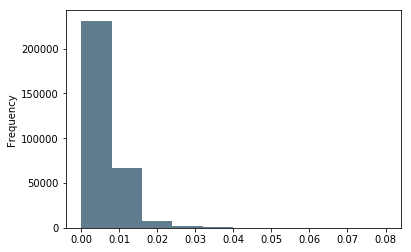

In [14]:
# Check distribution of scores
pd.Series(df['RISK_SCORE']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [15]:
hcc_score='RISK_SCORE'

# HCC score Gini         
metric_auc_hcc = metrics.roc_auc_score(df['RISK_FSTQPD30'], df[hcc_score])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.3429767906103425


In [16]:
df["TIME_DECISION_DATE"] = pd.to_datetime(df["TIME_DECISION_DATE"],format ='%d-%m-%y')

df["MONTH"]= df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

In [17]:
df_summ = df.groupby("MONTH").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

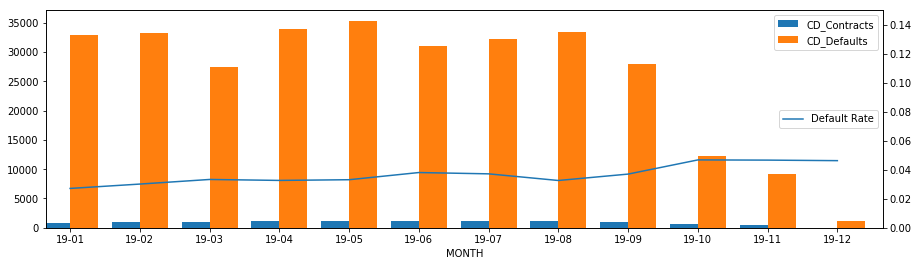

In [18]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [19]:
#MOM Gini Risk Score
for x in df["MONTH"].unique():
    try:   
        metric_auc_hcc = metrics.roc_auc_score(df[df["MONTH"]==x]['RISK_FSTQPD30'], df[df["MONTH"]==x][hcc_score])
        gini_hcc_only = 2 * metric_auc_hcc - 1
        print(x ,gini_hcc_only)  
    except:
        print("ERROR")

19-12 0.33116713352007476
19-11 0.36460336525606296
19-10 0.3685286766658198
19-09 0.39623314845167457
19-08 0.38086647188334544
19-07 0.339575230825349
19-06 0.3432410071403673
19-05 0.34980637328704645
19-04 0.32341942869724294
19-03 0.32532948507681425
19-02 0.335176446401507
19-01 0.32787385015497383


In [20]:
df["DATE_1"] = pd.to_datetime(df["DATE_1"],format ='%d-%m-%y')
df["DATE_2"] = pd.to_datetime(df["DATE_2"],format ='%d-%m-%y')
df["DATE_3"] = pd.to_datetime(df["DATE_3"],format ='%d-%m-%y')
df["DATE_4"] = pd.to_datetime(df["DATE_4"],format ='%d-%m-%y')
df["DATE_5"] = pd.to_datetime(df["DATE_5"],format ='%d-%m-%y')
df["DATE_6"] = pd.to_datetime(df["DATE_6"],format ='%d-%m-%y')

In [21]:
#Tenure Variables 
df["TENURE1"] = (df["TIME_DECISION_DATE"]-df["DATE_1"]).dt.days
df["TENURE2"] = (df["TIME_DECISION_DATE"]-df["DATE_2"]).dt.days
df["TENURE3"] = (df["TIME_DECISION_DATE"]-df["DATE_3"]).dt.days
df["TENURE4"] = (df["TIME_DECISION_DATE"]-df["DATE_4"]).dt.days
df["TENURE5"] = (df["TIME_DECISION_DATE"]-df["DATE_5"]).dt.days
df["TENURE6"] = (df["TIME_DECISION_DATE"]-df["DATE_6"]).dt.days




In [22]:
#One Hot Encoding
df_encoded = df
for x in ["CODE_1","CODE_2","CODE_3","CODE_4","CODE_5","CODE_6",'REASON_1_ENCODED', 'REASON_2_ENCODED',
       'REASON_3_ENCODED', 'REASON_4_ENCODED', 'REASON_5_ENCODED',
       'REASON_6_ENCODED']:
    
    dummy = pd.get_dummies(df_encoded[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df_encoded = pd.concat([df_encoded, dummy], axis=1)

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SKP_CREDIT_CASE,309659.0,2.408503e+08,1.647431e+07,2.198978e+08,2.289936e+08,2.370710e+08,2.467696e+08,2.887665e+08
RISK_AGRF180,309659.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
RISK_FPD30,309659.0,2.799854e-03,5.283961e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSPD30,309659.0,1.153850e-02,1.067961e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTPD30,309659.0,2.244727e-02,1.481333e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD30,309659.0,3.436684e-02,1.821699e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD60,309659.0,2.600926e-02,1.591630e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_SCORE,309659.0,6.228975e-03,5.496348e-03,1.616712e-04,2.901275e-03,4.981366e-03,8.050143e-03,2.732316e-01
AMT_DIRECT_DEBIT_STATEMENT,309659.0,2.504446e+03,1.683870e+03,0.000000e+00,1.476000e+03,1.893000e+03,2.847960e+03,1.820500e+04
AMT_1,309659.0,2.339608e+03,1.624468e+03,0.000000e+00,1.393000e+03,1.774000e+03,2.574000e+03,1.807200e+04


In [24]:
df = df_encoded

In [25]:
df_test = df[df["TIME_DECISION_DATE"]>= pd.datetime(2019,8,1)]
df_train = df[df["TIME_DECISION_DATE"]< pd.datetime(2019,8,1)]


In [26]:
x_column = ['AMT_DIRECT_DEBIT_STATEMENT','TENURE1', 'TENURE2', 'TENURE3', 'TENURE4',
       'TENURE5', 'TENURE6', 'Debited_CODE_1', 'Posted_CODE_1',
       'Undebited_CODE_1', 'Debited_CODE_2', 'Posted_CODE_2',
       'Undebited_CODE_2', 'Debited_CODE_3', 'Posted_CODE_3',
       'Undebited_CODE_3', 'Debited_CODE_4', 'Posted_CODE_4',
       'Undebited_CODE_4', 'Debited_CODE_5', 'Posted_CODE_5',
       'Undebited_CODE_5', 'Debited_CODE_6', 'Posted_CODE_6',
       'Undebited_CODE_6', 'DEBITED_REASON_1_ENCODED',
       'Others_REASON_1_ENCODED', 'PROCESS ISSUE_REASON_1_ENCODED',
       'WILLFULL DEFAULTS_REASON_1_ENCODED', 'DEBITED_REASON_2_ENCODED',
       'Others_REASON_2_ENCODED', 'PROCESS ISSUE_REASON_2_ENCODED',
       'WILLFULL DEFAULTS_REASON_2_ENCODED', 'DEBITED_REASON_3_ENCODED',
       'Others_REASON_3_ENCODED', 'PROCESS ISSUE_REASON_3_ENCODED',
       'WILLFULL DEFAULTS_REASON_3_ENCODED', 'DEBITED_REASON_4_ENCODED',
       'Others_REASON_4_ENCODED', 'PROCESS ISSUE_REASON_4_ENCODED',
       'WILLFULL DEFAULTS_REASON_4_ENCODED', 'DEBITED_REASON_5_ENCODED',
       'Others_REASON_5_ENCODED', 'PROCESS ISSUE_REASON_5_ENCODED',
       'WILLFULL DEFAULTS_REASON_5_ENCODED', 'DEBITED_REASON_6_ENCODED',
       'Others_REASON_6_ENCODED', 'PROCESS ISSUE_REASON_6_ENCODED',
       'WILLFULL DEFAULTS_REASON_6_ENCODED','RISK_SCORE']
y_column = 'RISK_FSTQPD30'

In [27]:
# split data into train and test sets
seed = 25522

X_test = df_test[x_column]
y_test = df_test[y_column]

X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)


##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train['RISK_SCORE'])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test['RISK_SCORE'])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid['RISK_SCORE'])*2 -1)



Event rate in train set : 3.25%

 Train set shape: (180744, 50)

Event rate in test set : 3.79%

 Test set shape: (83729, 50)

Event rate in validation set : 3.51%

 validation set shape: (45186, 50)

 Train GINI 0.3319617526604359

 Test GINI 0.35546757942792384

 validation GINI 0.34785006710089417


In [28]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [29]:
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train.drop(columns='RISK_SCORE'), np.ravel(y_train)),(X_valid.drop(columns='RISK_SCORE'), np.ravel(y_valid))]

bst = xgb_model.fit(X_train.drop(columns='RISK_SCORE'), np.ravel(y_train), eval_metric="auc", eval_set=evals,
                    early_stopping_rounds=40   ,  verbose=False)

In [30]:
imp = fimportances(bst,X_train.drop(columns='RISK_SCORE').columns)

In [31]:
bst1 = bst
X_train_1 = X_train.drop(columns='RISK_SCORE')
X_valid_1 = X_valid.drop(columns='RISK_SCORE')
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Gini Train":[0],"Gini Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 4):
    select_X_train = X_train_1[list(imp['predictor'])[:-2]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-2]]
    xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict_proba(select_X_train)[:, 1]
    ypred_test  = bst.predict_proba(select_X_valid)[:, 1]
    
    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_valid, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1
    
    print("Columns Remaining : %d , gini_train: %f,gini_test: %f "%(select_X_train.shape[1],gini_train,gini_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Gini Train'].append(gini_train)
    dic_imp['Gini Test'].append(gini_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 40 , gini_train: 0.163771,gini_test: 0.129772 
Columns Remaining : 35 , gini_train: 0.164986,gini_test: 0.127891 
Columns Remaining : 32 , gini_train: 0.158940,gini_test: 0.125201 
Columns Remaining : 28 , gini_train: 0.161991,gini_test: 0.126645 
Columns Remaining : 26 , gini_train: 0.164796,gini_test: 0.127556 
Columns Remaining : 24 , gini_train: 0.163450,gini_test: 0.127477 
Columns Remaining : 22 , gini_train: 0.171099,gini_test: 0.126410 
Columns Remaining : 20 , gini_train: 0.167457,gini_test: 0.127198 
Columns Remaining : 18 , gini_train: 0.160650,gini_test: 0.126530 
Columns Remaining : 16 , gini_train: 0.161568,gini_test: 0.126959 
Columns Remaining : 14 , gini_train: 0.166369,gini_test: 0.125455 
Columns Remaining : 12 , gini_train: 0.151996,gini_test: 0.119377 
Columns Remaining : 10 , gini_train: 0.148963,gini_test: 0.119057 
Columns Remaining : 8 , gini_train: 0.156421,gini_test: 0.118931 
Columns Remaining : 6 , gini_train: 0.142832,gini_test: 0.10863

In [32]:
df_imp =pd.DataFrame(dic_imp)

In [33]:
selected_vars = list(df_imp[df_imp['n']==14]["Predictors"])

In [34]:
selected_vars

[['AMT_DIRECT_DEBIT_STATEMENT',
  'TENURE6',
  'TENURE5',
  'TENURE2',
  'TENURE3',
  'TENURE1',
  'TENURE4',
  'WILLFULL DEFAULTS_REASON_1_ENCODED',
  'DEBITED_REASON_4_ENCODED',
  'Undebited_CODE_1',
  'Undebited_CODE_2',
  'DEBITED_REASON_2_ENCODED',
  'DEBITED_REASON_6_ENCODED',
  'WILLFULL DEFAULTS_REASON_3_ENCODED']]

In [35]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]

print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (180744, 14) 
 Test shape: (83729, 14) 
 Validation shape: (45186, 14)


In [36]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(4, random_state=1)

In [37]:
## XGB model## The model is pretty stable with default parameters(after variable selection), hence not tuning any more
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 5)
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'objective': 'binary:logistic', 'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBClassifier(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring=['roc_auc'], n_iter=20,
                         random_state=40, cv=kfolds.split(X_train_2, y_train), refit='roc_auc',error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..
Randomized search time: 1064.1421654224396
Best score: 0.569119372596227
Best params: 
colsample_bytree: 0.7000000000000002
learning_rate: 0.006
max_depth: 3
min_child_weight: 19
scale_pos_weight: 25
subsample: 0.55


In [38]:
pd.Series(dic['mean_train_roc_auc']).to_csv("mean_train_roc_auc_mesdq.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [39]:
pd.Series(dic['mean_test_roc_auc']).to_csv("mean_test_roc_auc_mesdq.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [40]:
pd.DataFrame(dic['params']).to_csv("params_mesdq.csv")

In [41]:
#First Run
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.006,
              subsample= 0.55,
              min_child_weight= 19,
              colsample_bytree= 0.7,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200
             )
#GINI TRAIN: 

#GINI Validation: 

#GINI CV: 

#Gini Test 

In [42]:
#if required
#%env JOBLIB_TEMP_FOLDER=/tmp

In [43]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    auc_cv = cross_val_score(xgb_model, X_tr, np.ravel(y_tr), scoring='roc_auc', cv=kfolds.split(X_tr, np.ravel(y_tr)),
                             n_jobs=1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict_proba(X_tr)[:, 1]
        ypred_test = bst.predict_proba(X_ts)[:, 1]
    else:
        ypred_train = bst.predict_proba(X_tr, ntree_limit=bst.best_ntree_limit)[:, 1]
        ypred_test = bst.predict_proba(X_ts, ntree_limit=bst.best_ntree_limit)[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_tr, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_ts, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    return bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test

In [44]:
## run xgboost
bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("GINI TRAIN:",gini_train )
print("\nGINI Validation:",gini_test )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.15940333260775263

GINI Validation: 0.12320888334856583

GINI CV: 0.13823873015893084


In [45]:
X_train_2.columns

Index(['AMT_DIRECT_DEBIT_STATEMENT', 'TENURE6', 'TENURE5', 'TENURE2',
       'TENURE3', 'TENURE1', 'TENURE4', 'WILLFULL DEFAULTS_REASON_1_ENCODED',
       'DEBITED_REASON_4_ENCODED', 'Undebited_CODE_1', 'Undebited_CODE_2',
       'DEBITED_REASON_2_ENCODED', 'DEBITED_REASON_6_ENCODED',
       'WILLFULL DEFAULTS_REASON_3_ENCODED'],
      dtype='object')

In [46]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict_proba(X_test_2, ntree_limit=bst.best_ntree_limit)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test 0.14881241304230897


In [47]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv(os.getcwd()+r"\xgb_cl_varimp_skp_client.csv",index=0)

In [48]:
importance_tbl

,predictor,importance
0,AMT_DIRECT_DEBIT_STATEMENT,0.229508
1,TENURE6,0.184426
2,TENURE5,0.090164
3,TENURE2,0.081967
4,TENURE4,0.063525
5,WILLFULL DEFAULTS_REASON_1_ENCODED,0.060451
6,TENURE3,0.054303
7,TENURE1,0.054303
8,DEBITED_REASON_4_ENCODED,0.050205
9,Undebited_CODE_1,0.037910


In [49]:
## save the model 
pickle.dump(bst, open(os.getcwd()+r"\model_clx_skp_client", "wb"))
##Score the dataset
outtest=X_test_2;  outtest['pred']=ypred_test ; outtest['act']=y_test ; 
outtest.to_csv(os.getcwd()+r"\clx_test_scored_skp_client.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [50]:
df["XGB_SCORE"] = bst.predict_proba(df[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

[[76781  3775]
 [ 2761   412]]

 Log Loss is : 0.6545496718148773
Average precision-recall score: 0.05


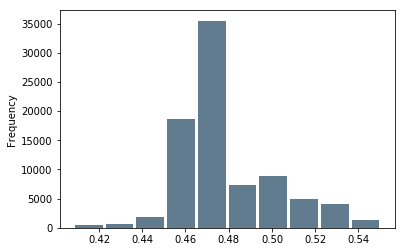

In [51]:
#metrics calculation
cutoff=np.percentile(X_test['RISK_SCORE'],95)
ypred=pd.Series(X_test['RISK_SCORE']).apply(lambda x : 1 if x >cutoff else 0 )
#ypred=pd.Series(ypred_test).apply(lambda x : 1 if x > 0.48631722 else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))

In [52]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

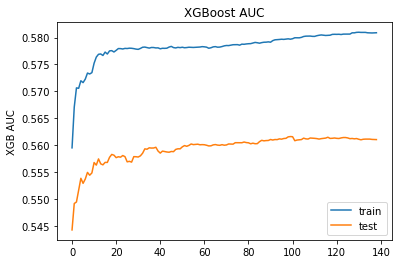

In [53]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')

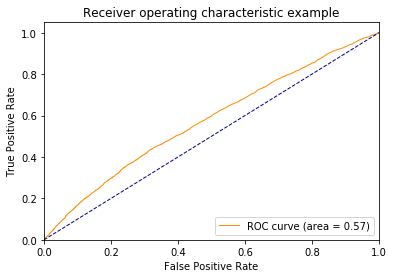

In [54]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.ravel(), ypred_test.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[]

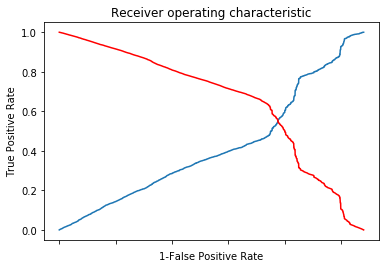

In [55]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [56]:
optimal_idx = np.argmax(tpr - fpr)  ## check it once 
optimal_threshold = thresholds[optimal_idx]
print("\n Optimal Cut off :",optimal_threshold)


 Optimal Cut off : 0.4790361


In [57]:
## Bad rates in overall population 
cd=pd.DataFrame(df[['RISK_SCORE','RISK_FSTQPD30']]).sort_values(by=['RISK_SCORE'],ascending=False)
print("\nTotal bad :",df['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/df['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).sum())


Total bad : 10642
Bad captured in worst category : 22.37%

                       RISK_SCORE  RISK_FSTQPD30
RISK_SCORE                                     
(-0.000838, 0.00174]    0.001240       0.008784
(0.00174, 0.00252]      0.002138       0.012950
(0.00252, 0.00328]      0.002900       0.018633
(0.00328, 0.00409]      0.003680       0.023090
(0.00409, 0.00498]      0.004526       0.027449
(0.00498, 0.00601]      0.005477       0.032121
(0.00601, 0.00726]      0.006601       0.038218
(0.00726, 0.00897]      0.008071       0.047052
(0.00897, 0.0116]       0.010182       0.058483
(0.0116, 0.273]         0.017475       0.076891
                      RISK_SCORE  RISK_FSTQPD30
RISK_SCORE                                     
(-0.000838, 0.00174]   38.403101            272
(0.00174, 0.00252]     66.209256            401
(0.00252, 0.00328]     89.798807            577
(0.00328, 0.00409]    113.954185            715
(0.00409, 0.00498]    140.152074            850
(0.00498, 0.00601]    169.6

In [58]:
## Bad rates in overall population 
cdt=pd.DataFrame(outtest[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 16.42%

Total bads in test sample: 3173
                    pred       act
pred                              
(0.407, 0.455]  0.447477  0.026124
(0.455, 0.459]  0.456214  0.030479
(0.459, 0.471]  0.464375  0.028617
(0.471, 0.472]  0.472052  0.035261
(0.472, 0.474]  0.473142  0.033492
(0.474, 0.475]  0.474631  0.034237
(0.475, 0.482]  0.477237  0.035641
(0.482, 0.499]  0.490490  0.043592
(0.499, 0.513]  0.504343  0.049200
(0.513, 0.55]   0.526512  0.062231
                       pred  act
pred                            
(0.407, 0.455]  3751.198486  219
(0.455, 0.459]  3936.673340  263
(0.459, 0.471]  3764.688477  232
(0.471, 0.472]  4056.341553  303
(0.472, 0.474]  3870.773438  274
(0.474, 0.475]  3992.594727  288
(0.475, 0.482]  3963.452881  296
(0.482, 0.499]  4106.875488  365
(0.499, 0.513]  4223.366699  412
(0.513, 0.55]   4407.956543  521


In [59]:
## Pillar  approach to combine score
hcc_score = 'RISK_SCORE'
X_pillar_train = pd.DataFrame()
X_pillar_test = pd.DataFrame()

X_pillar_train[hcc_score]=df_train['RISK_SCORE']; 
X_pillar_test[hcc_score]=df_test['RISK_SCORE']

X_pillar_train["XGB_SCORE"] =  bst.predict_proba(df_train[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]
X_pillar_test["XGB_SCORE"]  =  bst.predict_proba(df_test[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

X_pillar_train["FSTQ"] = df_train['RISK_FSTQPD30']
X_pillar_test["FSTQ"] = df_test['RISK_FSTQPD30']

X_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['RISK_SCORE','XGB_SCORE']]
y_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['FSTQ']]

X_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['RISK_SCORE','XGB_SCORE']]
y_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['FSTQ']]

X_train_log = np.log((X_train_log + 1e-10).divide(1 - (X_train_log + 1e-10)))
X_test_log = np.log((X_test_log + 1e-10).divide(1 - (X_test_log + 1e-10)))




In [60]:
df["RISK_SCORE_LOG"]= np.log((df["RISK_SCORE"] + 1e-10).divide(1 - (df["RISK_SCORE"] + 1e-10)))
df["XGB_SCORE_LOG"]= np.log((df["XGB_SCORE"] + 1e-10).divide(1 - (df["XGB_SCORE"] + 1e-10)))


In [61]:
logreg = LogisticRegression(C=11, n_jobs=cpu)

# cross validation gini
kfolds = StratifiedKFold(10, random_state=1)
auc_cv = cross_val_score(logreg, X_train_log, np.ravel(y_train_log), scoring='roc_auc',
                         cv=kfolds.split(X_test_log, np.ravel(y_test_log)), n_jobs=cpu)
gini_cv = (2 * np.array(auc_cv) - 1).mean()

logreg.fit(X_train_log, np.ravel(y_train_log))
log_coef_tbl = pd.DataFrame({'predictor': ['intercept'] + X_train_log.columns.tolist(),
                             'coefficient': list(logreg.intercept_) + list(logreg.coef_[0])})
log_coef_tbl = log_coef_tbl[['predictor', 'coefficient']]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [62]:
log_coef_tbl

,predictor,coefficient
0,intercept,1.304429
1,RISK_SCORE,0.867313
2,XGB_SCORE,2.190101


In [63]:
## Model performance
ypred_train_pillar = logreg.predict_proba(X_train_log)[:, 1]
metric_auc_train_log = metrics.roc_auc_score(np.ravel(y_train_log), ypred_train_pillar)
gini_train_pillar = 2 * metric_auc_train_log - 1
ypred_test_pillar = logreg.predict_proba(X_test_log)[:, 1]
metric_auc_test_log = metrics.roc_auc_score(np.ravel(y_test_log), ypred_test_pillar)
gini_test_pillar = 2 * metric_auc_test_log - 1

print("GINI TRAIN:",gini_train_pillar )
print("GINI TEST:",gini_test_pillar )
print("GINI CV:",gini_cv)

GINI TRAIN: 0.35388594063059875
GINI TEST: 0.3703018199373165
GINI CV: 0.36181319952182855


In [64]:
df["COMBINED_SCORE"] = logreg.predict_proba(df[['RISK_SCORE_LOG', 'XGB_SCORE_LOG']])[:, 1]

In [65]:
print("COMBINED:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["COMBINED_SCORE"])-1)
print("RISK:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["RISK_SCORE"])-1)
print("XGB:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["XGB_SCORE"])-1)


COMBINED: 0.35989129291669886
RISK: 0.3429767906103425
XGB: 0.1518877120271438


In [66]:
df.to_pickle(os.getcwd()+"\scored_clx_skp_client.pkl")

In [67]:
df.to_csv(os.getcwd()+"\scored_clx_skp_client.csv")

In [68]:
outtest1=df_train;  outtest1['pred']=ypred_train_pillar ; outtest1['act']=ypred ; 
# outtest1.to_csv(r"clx\\comb_cd_fstq_clx_mix.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[[76822  2720]
 [ 3734   453]]


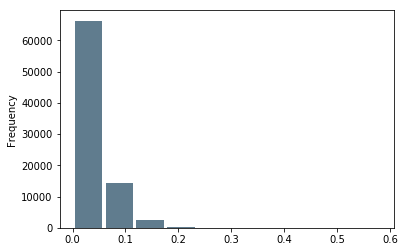

In [69]:
#metrics calculation
cutoff=np.percentile(ypred_test_pillar,95)
ypred=pd.Series(ypred_test_pillar).apply(lambda x : 1 if x >cutoff else 0 )

print(confusion_matrix(ypred,df_test['RISK_FSTQPD30'] ))
pd.Series(ypred_test_pillar).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

In [70]:
print("\n Log Loss is :",log_loss(df_test['RISK_FSTQPD30'], ypred_test_pillar))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(df_test['RISK_FSTQPD30'], ypred_test_pillar)))


 Log Loss is : 0.15320629686977472
Average precision-recall score: 0.09


In [71]:
len(ypred_test_pillar)

83729

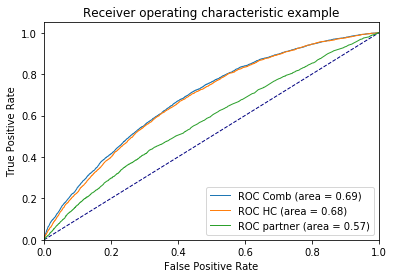

In [72]:
## PRC curve
#precision, recall, _ = precision_recall_curve(ypred, ypred_test_pillar)

# step_kwargs = ({'step': 'post'}
#                #if 'step' in signature(plt.fill_between).parameters
#                #else {}
#               )
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 0.5])
# plt.xlim([0.0, 0.5])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(test['RISK_FSTQPD30'], ypred_test_pillar)))

# # calculate precision-recall AUC
# auc_pr = auc(recall, precision)
# print("\n AUC for precision-recall :",auc_pr)

# Compute micro-average ROC curve and ROC area
fprhc, tprhc, thresholds = roc_curve(df_test['RISK_FSTQPD30'], df_test['RISK_SCORE'].ravel())
roc_auchc = auc(fprhc, tprhc)

fprc, tprc, thresholds = roc_curve(df_test['RISK_FSTQPD30'], ypred_test_pillar.ravel())
roc_aucc = auc(fprc, tprc)

plt.figure()
lw = 1
plt.plot(fprc, tprc, lw=lw, label='ROC Comb (area = %0.2f)' % roc_aucc)
plt.plot(fprhc, tprhc, lw=lw, label='ROC HC (area = %0.2f)' % roc_auchc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, lw=lw, label='ROC partner (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [73]:
## Bad rates combined score in overall population 
cdt=pd.DataFrame(outtest1[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Bad captured in worst category Partner Score test sample : nan%

Total bads in test sample: 0.0
                                     pred  act
pred                                          
(0.0005399999999999999, 0.0115]  0.008539  NaN
(0.0115, 0.0157]                 0.013661  NaN
(0.0157, 0.0197]                 0.017728  NaN
(0.0197, 0.0238]                 0.021718  NaN
(0.0238, 0.0282]                 0.025942  NaN
(0.0282, 0.0333]                 0.030666  NaN
(0.0333, 0.0394]                 0.036231  NaN
(0.0394, 0.0476]                 0.043306  NaN
(0.0476, 0.06]                   0.053162  NaN
(0.06, 0.623]                    0.079644  NaN
                                        pred  act
pred                                             
(0.0005399999999999999, 0.0115]   192.916275  0.0
(0.0115, 0.0157]                  308.631997  0.0
(0.0157, 0.0197]                  400.532590  0.0
(0.0197, 0.0238]                  490.666499  0.0
(0.0238, 0.0282]                  586.11